In [3]:
from pandas import read_parquet, concat
from pathlib import Path
from json import load
import seaborn as sns
from matplotlib import pyplot as plt

In [76]:
data_path = Path("data/matmul_vector_matrix")

def load_data(paths):
   dataframes = []
   for path in paths:
      dataframe = read_parquet(path)
      dataframe["Matrix name"] = path.parent.stem.capitalize().replace("_", " ")
      scipy_metadata_path = next(data_path.rglob(f"{path.stem}*.json"))
      if scipy_metadata_path:
         with scipy_metadata_path.open() as file_handle:
            scipy_metadata = load(file_handle)
         for key, value in scipy_metadata.items():
            dataframe[key] = value
      dataframes.append(dataframe)
   return concat(dataframes).reset_index()

cpu_paths = data_path.rglob("cpu*.parquet")
cpu_timings = load_data(cpu_paths)
cpu_timings["duration_normalised"] = cpu_timings["duration"] / cpu_timings["number"] / cpu_timings["function_iterations"]
cpu_fastest = cpu_timings.loc[cpu_timings.groupby(["Matrix name", "sparse_format", "operation_method"])["duration_normalised"].idxmin()]
cpu_fastest["duration_normalised"] = cpu_timings["duration_normalised"] * 1_000
cpu_fastest = cpu_fastest.rename(columns={"operation_method": "Method"})
cpu_fastest

,index,device,Method,sparse_format,duration,Matrix name,duration_seconds,number,repeat,function_iterations,duration_normalised
4,4,cpu,iterative,bsr,12.003945,Dairy cow acyclic,124.434352,1000,10,1,12.003945
18,8,cpu,once,bsr,12.023925,Dairy cow acyclic,121.337752,1,10,1000,12.023925
21,1,cpu,iterative,csc,1.975638,Dairy cow acyclic,20.212832,1000,10,1,1.975638
38,8,cpu,once,csc,1.923758,Dairy cow acyclic,20.073671,1,10,1000,1.923758
40,0,cpu,iterative,csr,1.966035,Dairy cow acyclic,20.356666,1000,10,1,1.966035
59,9,cpu,once,csr,1.903451,Dairy cow acyclic,20.160054,1,10,1000,1.903451
67,7,cpu,iterative,bsr,10.471253,Dairy cow cyclic,124.434352,1000,10,1,10.471253
74,4,cpu,once,bsr,10.451061,Dairy cow cyclic,121.337752,1,10,1000,10.451061
83,3,cpu,iterative,csc,1.778493,Dairy cow cyclic,20.212832,1000,10,1,1.778493
93,3,cpu,once,csc,1.829719,Dairy cow cyclic,20.073671,1,10,1000,1.829719


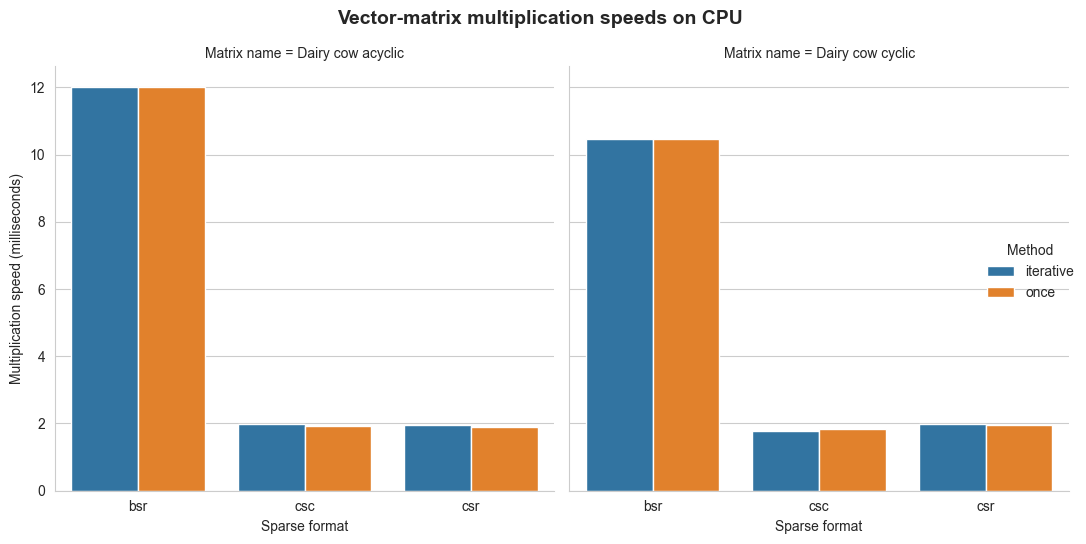

In [85]:
g = sns.catplot(data=cpu_fastest, x="sparse_format", y="duration_normalised", col="Matrix name", kind="bar", hue="Method", height=5.5, aspect=.9)
g.set_axis_labels("Sparse format", "Multiplication speed (milliseconds)")
g.fig.suptitle("Vector-matrix multiplication speeds on CPU", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("matmul_vector_matrix_cpu.svg")
plt.show()

In [83]:
gpu_paths = data_path.rglob("gpu*.parquet")
gpu_timings = load_data(gpu_paths)
gpu_timings["duration_normalised"] = gpu_timings["duration_gpu"] / gpu_timings["number"]
gpu_fastest = gpu_timings.loc[gpu_timings.groupby(["Matrix name", "sparse_format", "operation_method"])["duration_normalised"].idxmin()]
gpu_fastest["duration_normalised"] = gpu_fastest["duration_normalised"] * 1_000
gpu_fastest = gpu_fastest.rename(columns={"operation_method": "Method"})
gpu_fastest

,index,device,Method,sparse_format,duration_cpu,duration_gpu,Matrix name,duration_seconds,number,repeat,warmup,duration_normalised
3,3,gpu,iterative,coo,22.320127,22.324977,Dairy cow acyclic,683.384158,1000,10,20,22.324977
6286,6276,gpu,once,coo,0.016209,0.022004,Dairy cow acyclic,236.136829,1,10000,20,22.004192
10010,0,gpu,iterative,csc,0.092247,0.174504,Dairy cow acyclic,5.267730,1000,10,20,0.174504
15431,5411,gpu,once,csc,0.000105,0.000195,Dairy cow acyclic,3.782123,1,10000,20,0.194560
20022,2,gpu,iterative,csr,0.099633,0.185361,Dairy cow acyclic,5.628853,1000,10,20,0.185361
29837,9807,gpu,once,csr,0.000175,0.000198,Dairy cow acyclic,3.842600,1,10000,20,0.197664
30035,5,gpu,iterative,coo,22.294248,22.299102,Dairy cow cyclic,683.384158,1000,10,20,22.299102
38856,8816,gpu,once,coo,0.016360,0.022102,Dairy cow cyclic,236.136829,1,10000,20,22.101889
40048,8,gpu,iterative,csc,0.115199,0.173482,Dairy cow cyclic,5.267730,1000,10,20,0.173482
44089,4039,gpu,once,csc,0.000106,0.000189,Dairy cow cyclic,3.782123,1,10000,20,0.189056


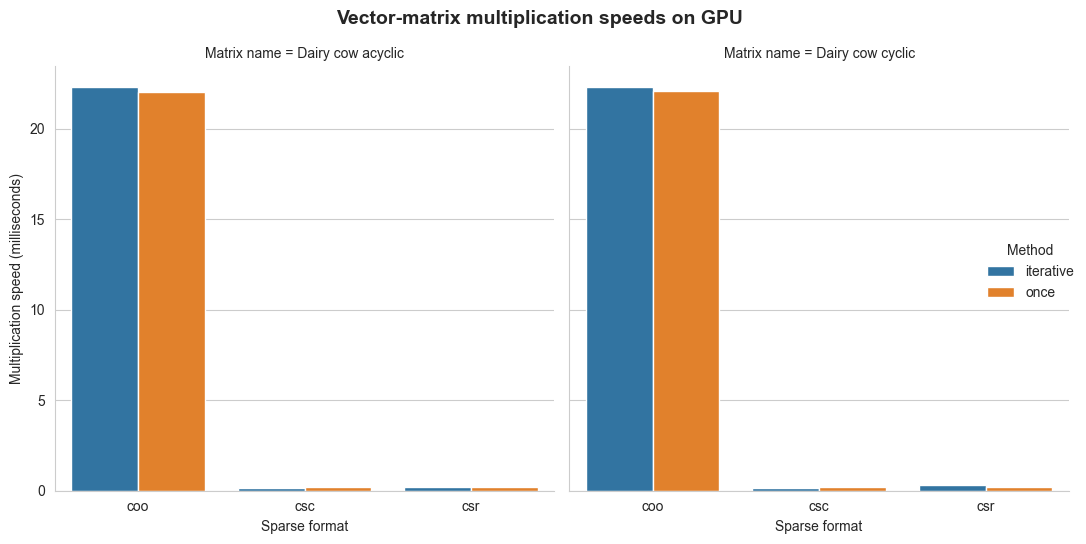

In [86]:
g = sns.catplot(data=gpu_fastest, x="sparse_format", y="duration_normalised", col="Matrix name", kind="bar", hue="Method", height=5.5, aspect=.9)
g.set_axis_labels("Sparse format", "Multiplication speed (milliseconds)")
g.fig.suptitle("Vector-matrix multiplication speeds on GPU", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("matmul_vector_matrix_gpu.svg")
plt.show()